# TP - Challenge Sigfox Geoloc - IoT
Groupe : 
- Alba Ordonez
- Karine Petrus
- Ioan Catana
- Stéphane Mulard

# Introduction - Problématique

Le challenge consiste à retrouver la position exacte d'un ensemble de messages émis par des objets connectés pouvant être en mouvement ou non (devices), à partir des informations reçues par les stations Sigfox qui les ont captés.

2 jeux de données ont été fournis :
- **Un ensemble d'entraînement** des données de messages (mess_train_list.csv) complété par la vraie localisation de chaque message (pos_train_list.csv)
- **Un ensemble de test** (mess_test_list.csv) sur lequel nous appliquerons le modèle de prédiction, mais pour lequel nous n'avons pas les positions réelles. Les prédictions des positions de ces messages constituent le rendu final qui sera évalué.

# Présentation générale des données


## Importations des packages nécessaires

In [110]:
#########################################
# Imports et paramétrage des graphiques #
#########################################

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import Image, IFrame
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn import model_selection
sns.set_style("white")

# Parameters of the plots
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

Après le chargement des données dans des DataFrame Pandas, nous avons réalisé une première exploration pour mieux en comprendre les caractéristiques.

## Description de base

Le dataframe d'apprentissage est décrit par les colonnes suivantes.
- **messid** : l'identifiant unique du message
- **bsid** : l'identifiant unique de la station ayant reçu le message
- **bs_lat** et **bs_lng**  : la latitude et la longitude de la station ayant reçu le message
- **did** : l'identifiant unique du device ayant émis le message
- **rssi** : la puissance du signal reçu par la station
- **time_ux** : la vitesse du message entre le device et la station
- **nseq** : un numéro de séquence de sécurité dont nous ne savons pas grand chose si ce n'est qu'il est corrélé au fait que le device ait tenté plusieurs fois d'emettre son message ou non, au cas où celui-ci n'aurait pas été bien capté (à vérifier).

Comme le montrent nous premières explorations, ce jeu d'apprentissage comporte :
- **39 250 lignes**, soit autant de messages captés par les différentes stations.
- **251 stations uniques** ayant capté ces messages
- **113 devices uniques** les ayant émis.
- **6 068 messages uniques** : reçus par une ou plusieurs stations.

Le jeu de test final est quant à lui constitué de :
- **29 286 lignes** soit autant de messages reçus par toutes les stations présente dans le fichier
- **168 stations uniques**, mais dont seulement 8 stations de plus que jeu d'apprentissage
- **56 devices uniques**, tous différents des devices du jeu d'apprentissage
- **5 294 messages uniques**

D'une manière générale l'ensemble des données (apprentissage + test) représente :
- **259 stations uniques** dont 8 sont exclusive au jeu de test
- **169 devices**

## Localisation des stations et messages

Comme le montre la carte ci-dessous, on constate que la grande majorité des stations et des messages émis se trouvent aux **Etats-Unis** et plus précisément fortement concentrés autour de la ville de **Denver**, dans l'état du **Colorado**. Cependant la distribution globale des messages et des stations montrent qu'ils semblent suivre un segment de droite qui part du centre du Wyoming et descend jusqu'à la pointe du Texas et l'extrémité ouest de l'Oklahoma.

Légende de la carte selon les points
- Les points **verts** représentent les vrais positions des messages émis
- Les points **rouge** représentent les positions des stations du jeu d'entraînement
- Les points **bleus** représentent les positions des stations du jeu de test

**TODO** inclure une carte zoomée sur Denver

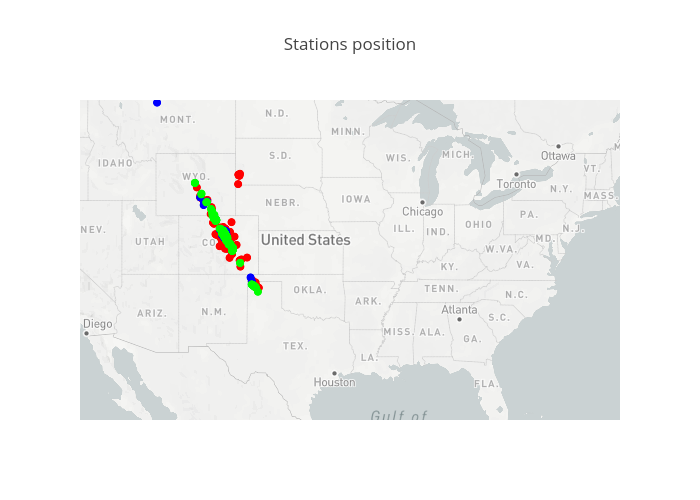

In [111]:
Image(filename='VisionGobaleMessagesStations.png', width=800)

## Erreur de localisation des stations

Cependant nos différentes visualisations et recherches nous ont montré qu'un certain nombre de stations étaient mal positionnées - probablement des données modifiées à dessein pour l'exercice (!). En effet 23 stations apparaissent positionnées très loin au Canada, près du Groënland, où Sigfox n'a pas de station selon le site web officiel. De plus ces 23 stations ont toutes les mêmes coordonnées de longitude et de latitude, ce qui est très suspicieux. Enfin, ces stations mal positionnées reçoivent pourtant des messages émis du Colorado...

Ces éléments nous ont amenés à trouver des moyens pour corriger et prédire la position initiale de ces stations, de façon à améliorer notre score, comme cela est décrit plus loin.

**TODO** : inclure la carte avec le point au Canada

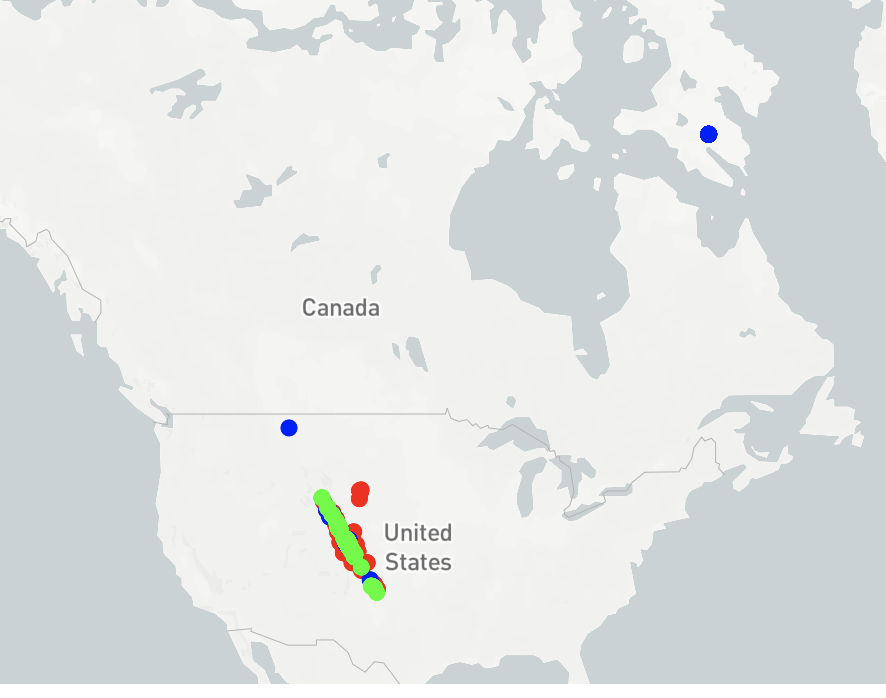

In [112]:
Image(filename='DezoomStationsWorld.png', width=500)

# Exploration des données

## Premières analyses

Nous avons procédé à plusieurs visualisations et recherches pour mieux comprendre la distribution de chacun des features, à la fois dans le jeu d'apprentissage et dans le jeu de test. Les commentaires suivent le code et les graphiques.

### Corrélations des variables

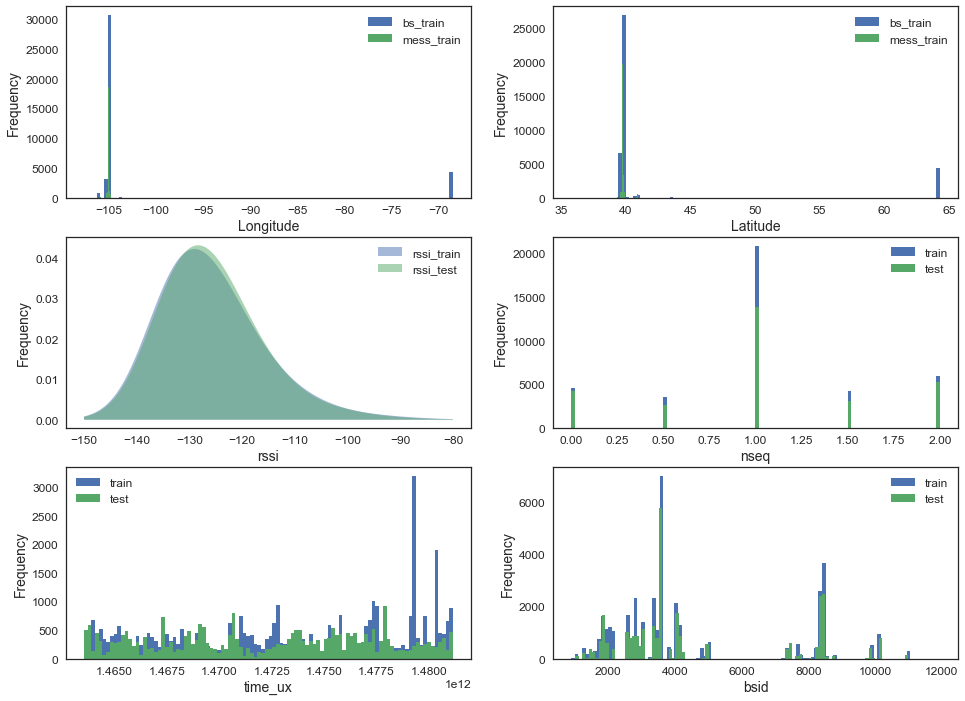

In [113]:
#############################################################
# Chargement des données à partir des fichiers csv de base  #
#############################################################

df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
plt.hist(df_mess_train['bs_lng'], bins= 100, label='bs_train')
plt.hist(pos_train['lng'], bins= 100, label='mess_train')
plt.ylabel("Frequency")
plt.xlabel("Longitude")
plt.legend()

plt.subplot(3,2,2)
plt.hist(df_mess_train['bs_lat'], bins= 100, label='bs_train')
plt.hist(pos_train['lat'], bins= 100, label='mess_train')
plt.ylabel("Frequency")
plt.xlabel("Latitude")
plt.legend()

plt.subplot(3,2,3)
x_grid = np.linspace(-150, -80, 1000)
kde_rssi = KDEUnivariate(df_mess_train['rssi'])
kde_rssi.fit(bw=5, kernel='gau')
pdf_rssi = kde_rssi.evaluate(x_grid)
kde_rssi_test = KDEUnivariate(df_mess_test['rssi'])
kde_rssi_test.fit(bw=5, kernel='gau')
pdf_rssi_test = kde_rssi_test.evaluate(x_grid)
plt.fill_between(x_grid, pdf_rssi, alpha=0.5, label='rssi_train')
plt.ylabel("Frequency")
plt.xlabel("rssi")
plt.fill_between(x_grid, pdf_rssi_test, alpha=0.5, label='rssi_test')
plt.ylabel("Frequency")
plt.xlabel("rssi")
plt.legend()

plt.subplot(3,2,4)
plt.hist(df_mess_train['nseq'], bins= 100, label='train')
plt.hist(df_mess_test['nseq'], bins= 100, label='test')
plt.ylabel("Frequency")
plt.xlabel("nseq")
plt.legend()

plt.subplot(3,2,5)
plt.hist(df_mess_train['time_ux'], bins= 100, label='train')
plt.hist(df_mess_test['time_ux'], bins= 100, label='test')
plt.ylabel("Frequency")
plt.xlabel("time_ux")
plt.legend()

plt.subplot(3,2,6)
plt.hist(df_mess_train['bsid'], bins= 100, label='train')
plt.hist(df_mess_test['bsid'], bins= 100, label='test')
plt.ylabel("Frequency")
plt.xlabel("bsid")
plt.legend()

- Pour ce qui concerne la latitude et la longitude des stations, ces graphiques confirment nos observations précédente sur la présence d'outliers, que ce soit au niveau du test ou du train.
- De manière générale, les jeus d'apprentissage et de test sont très similaires si ce n'est que le jeu de test a moins de messages, ce qui explique les fréquences moindres.
- La moyenne de puisssance du signal reçu se situe autour de 130 Dbm
- La répartition des valeurs nseq est assez surprenante car très symétrique autour de 1, mais sans savoir ce que signifie exactement ce nombre, il est difficile d'en tirer des conclusions. Probablement que pour l'essentiel des messages la transmission se déroule correctement avec 1.
- La répartition des time_ux est hétérogène avec des piques significatifs autour de 1.48e12.

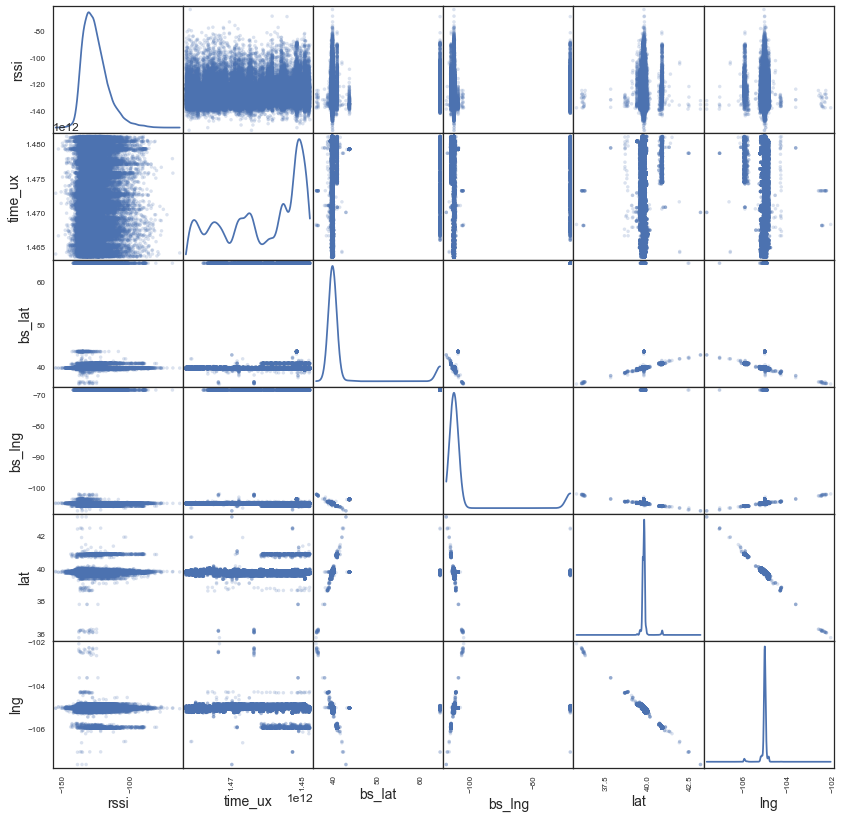

In [114]:
df_mess_pos = df_mess_train.copy()
df_mess_pos[['lat', 'lng']] = pos_train
with sns.axes_style('white'): 
    small_df=df_mess_pos[['rssi', 'time_ux', 'bs_lat', 'bs_lng', 'lat', 'lng']] 
    pd.plotting.scatter_matrix(small_df, figsize=(14, 14), diagonal="kde", alpha=0.2) 

plt.show()

Les corrélations ci-dessus montrent également qu'il y a une relation linéraire évidente entre les latitudes/longitudes des stations et les latitudes/longitudes des messages, ce que l'on a vérifié sur les cartes.

### Distribution des messages par station

Text(0.5, 1.0, 'Fréquence des messages reçus par station test')

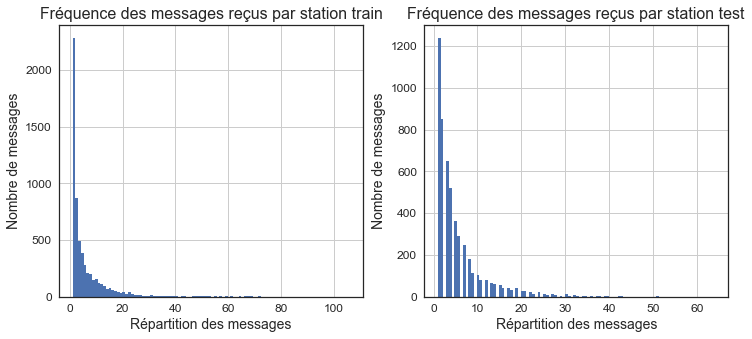

In [115]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) 
df_mess_bs_group.count().sort_values(by='bsid',ascending=False)["bsid"].hist(bins=100)
plt.xlabel("Répartition des messages")
plt.ylabel("Nombre de messages")
plt.title("Fréquence des messages reçus par station train")

plt.subplot(1,2,2)
df_mess_bs_group_test = df_mess_test.groupby(['messid'], as_index=False) 
df_mess_bs_group_test.count().sort_values(by='bsid',ascending=False)["bsid"].hist(bins=100)
plt.xlabel("Répartition des messages")
plt.ylabel("Nombre de messages")
plt.title("Fréquence des messages reçus par station test")

In [116]:
df_count_messid = df_mess_train.groupby(['messid'], as_index=False).count()
df_count_messid[(df_count_messid['bsid'] == 1)].shape[0]
df_count_messid[(df_count_messid['bsid'] == 1) | (df_count_messid['bsid'] == 2)].shape[0]

2282

In [117]:
data = df_mess_train.groupby(['messid']).count()["bsid"]
data_with_3_pos_more = data[data>3].count()
data_with_3_pos = data[data==3].count()
data_with_2_pos = data[data==2].count()
data_with_1_pos = data[data==1].count()

print(f"NTotal number of messages: {data.shape[0]}")
print("Messages received by more than 3 stations : %2.2f" %(data_with_3_pos_more / data.shape[0] * 100), "%")
print("Messages received by 3 stations: %2.2f" %(data_with_3_pos / data.shape[0] * 100), "%")
print("Messages received by 2 stations: %2.2f" %(data_with_2_pos / data.shape[0] * 100), "%")
print("Messages received by one station: %2.2f" %(data_with_1_pos /data.shape[0] * 100), "%")

NTotal number of messages: 6068
Messages received by more than 3 stations : 47.97 %
Messages received by 3 stations: 14.42 %
Messages received by 2 stations: 15.71 %
Messages received by one station: 21.90 %


Nous avons constaté les répartitions suivantes des messages reçus par station. Parmi les 6068 messages émis :
- 1329 ont été reçus uniquement par 1 station
- 953 ont été reçus uniquement par 2 stations
- 3786 ont été reçus par 3 stations ou plus

Autrement dit, plus d'un tiers des messages n'ont été reçus que par 1 ou 2 stations. Ce dernier constat signifie qu'il serait difficile de procéder à une triangularisation pour retrouver la position originale de ces messages.

#### Comptage du nombre des messages reçus par chaque station

In [291]:
df_mess_all = pd.concat([df_mess_train, df_mess_test])
df_bsid_count_mess = df_mess_all.groupby(['bsid'], as_index=False).count()\
    .sort_values(by='messid',ascending=False)[['bsid','messid']]
df_bsid_count_mess.columns = ['bsid','bs_count_mess']
df_bsid_count_mess.head()

,bsid,bs_count_mess
44,1859,1796
46,1878,1720
89,3025,1630
159,4058,1489
126,3562,1472


In [292]:
df_bsid_count_mess.describe()

,bsid,bs_count_mess
count,259.000000,259.000000
mean,4520.640927,264.617761
std,2728.008223,385.647503
min,879.000000,1.000000
25%,2767.000000,3.000000
50%,3568.000000,50.000000
75%,7641.500000,385.000000
max,11951.000000,1796.000000


En moyenne une station recoit 265 messages sur les deux datasets(train et test) reunis.<br> Le maximum de messages recus par une station (1859) est de 1796. Il existe aussi des stations qui ont recu qu'un seul message.

### Distribution des messages par device

Text(0.5, 1.0, 'Fréquence des messages reçus, par device test')

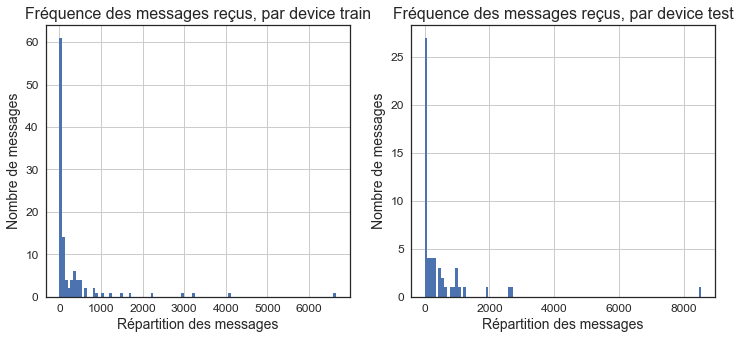

In [118]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df_mess_bs_group = df_mess_train.groupby(['did'], as_index=False) 
df_mess_bs_group.count().sort_values(by='messid',ascending=False)["messid"].hist(bins=100)
plt.xlabel("Répartition des messages")
plt.ylabel("Nombre de messages")
plt.title("Fréquence des messages reçus, par device train")

plt.subplot(1,2,2)
df_mess_bs_group_test = df_mess_test.groupby(['did'], as_index=False) 
df_mess_bs_group_test.count().sort_values(by='messid',ascending=False)["messid"].hist(bins=100)
plt.xlabel("Répartition des messages")
plt.ylabel("Nombre de messages")
plt.title("Fréquence des messages reçus, par device test")

In [119]:
df_mess_bs_group.count().describe()

,did,messid,bsid,nseq,rssi,time_ux,bs_lat,bs_lng
count,1.130000e+02,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,4.984681e+05,347.345133,347.345133,347.345133,347.345133,347.345133,347.345133,347.345133
std,1.684017e+05,873.236240,873.236240,873.236240,873.236240,873.236240,873.236240,873.236240
min,4.732880e+05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.762100e+05,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
50%,4.763230e+05,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
75%,4.766090e+05,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
max,1.747448e+06,6653.000000,6653.000000,6653.000000,6653.000000,6653.000000,6653.000000,6653.000000


In [120]:
df_mess_train[df_mess_train["did"]==476185.0].groupby(["bsid"], as_index=False).count()\
                                             .sort_values(by="messid", ascending=False).head(20)

,bsid,messid,did,nseq,rssi,time_ux,bs_lat,bs_lng
16,2189,536,536,536,536,536,536,536
11,1878,337,337,337,337,337,337,337
108,8470,318,318,318,318,318,318,318
48,3538,298,298,298,298,298,298,298
41,3412,226,226,226,226,226,226,226
105,8446,213,213,213,213,213,213,213
50,3545,206,206,206,206,206,206,206
15,1996,196,196,196,196,196,196,196
14,1994,196,196,196,196,196,196,196
26,2790,179,179,179,179,179,179,179


De ces chiffres, on constate plusieurs faits intéressants :
- Il semblerait qu'il y ait plusieurs devices outlier dans la mesure où ils seraient responsable de plusieurs milliers de messages reçus, tandis que la majorité se situe autour de 300 messages reçus.
- Un device en particulier, le numéro "476185" a généré 6653 messages reçus à lui tout seul sur les 39250, captés par 121 stations différentes, soit près de la moitié des stations présentes. Sur ces 6653, certaines stations ont reçus jusqu'à 536 messages en provenance de ce device.

Nous pourrions réfléchir à un traitement spécifique pour ce device. La carte ci-dessous montre les messages émis par ce device en verts et les stations qui les ont reçus en rouge. Ce qui est certain c'est que ce device a beaucoup voyagé ! Comme nous ne disposons pas de l'échele de temps, il est impossible de savoir si cela est réaliste ou non. Il pourrait d'agir d'un coursier, par exemple.

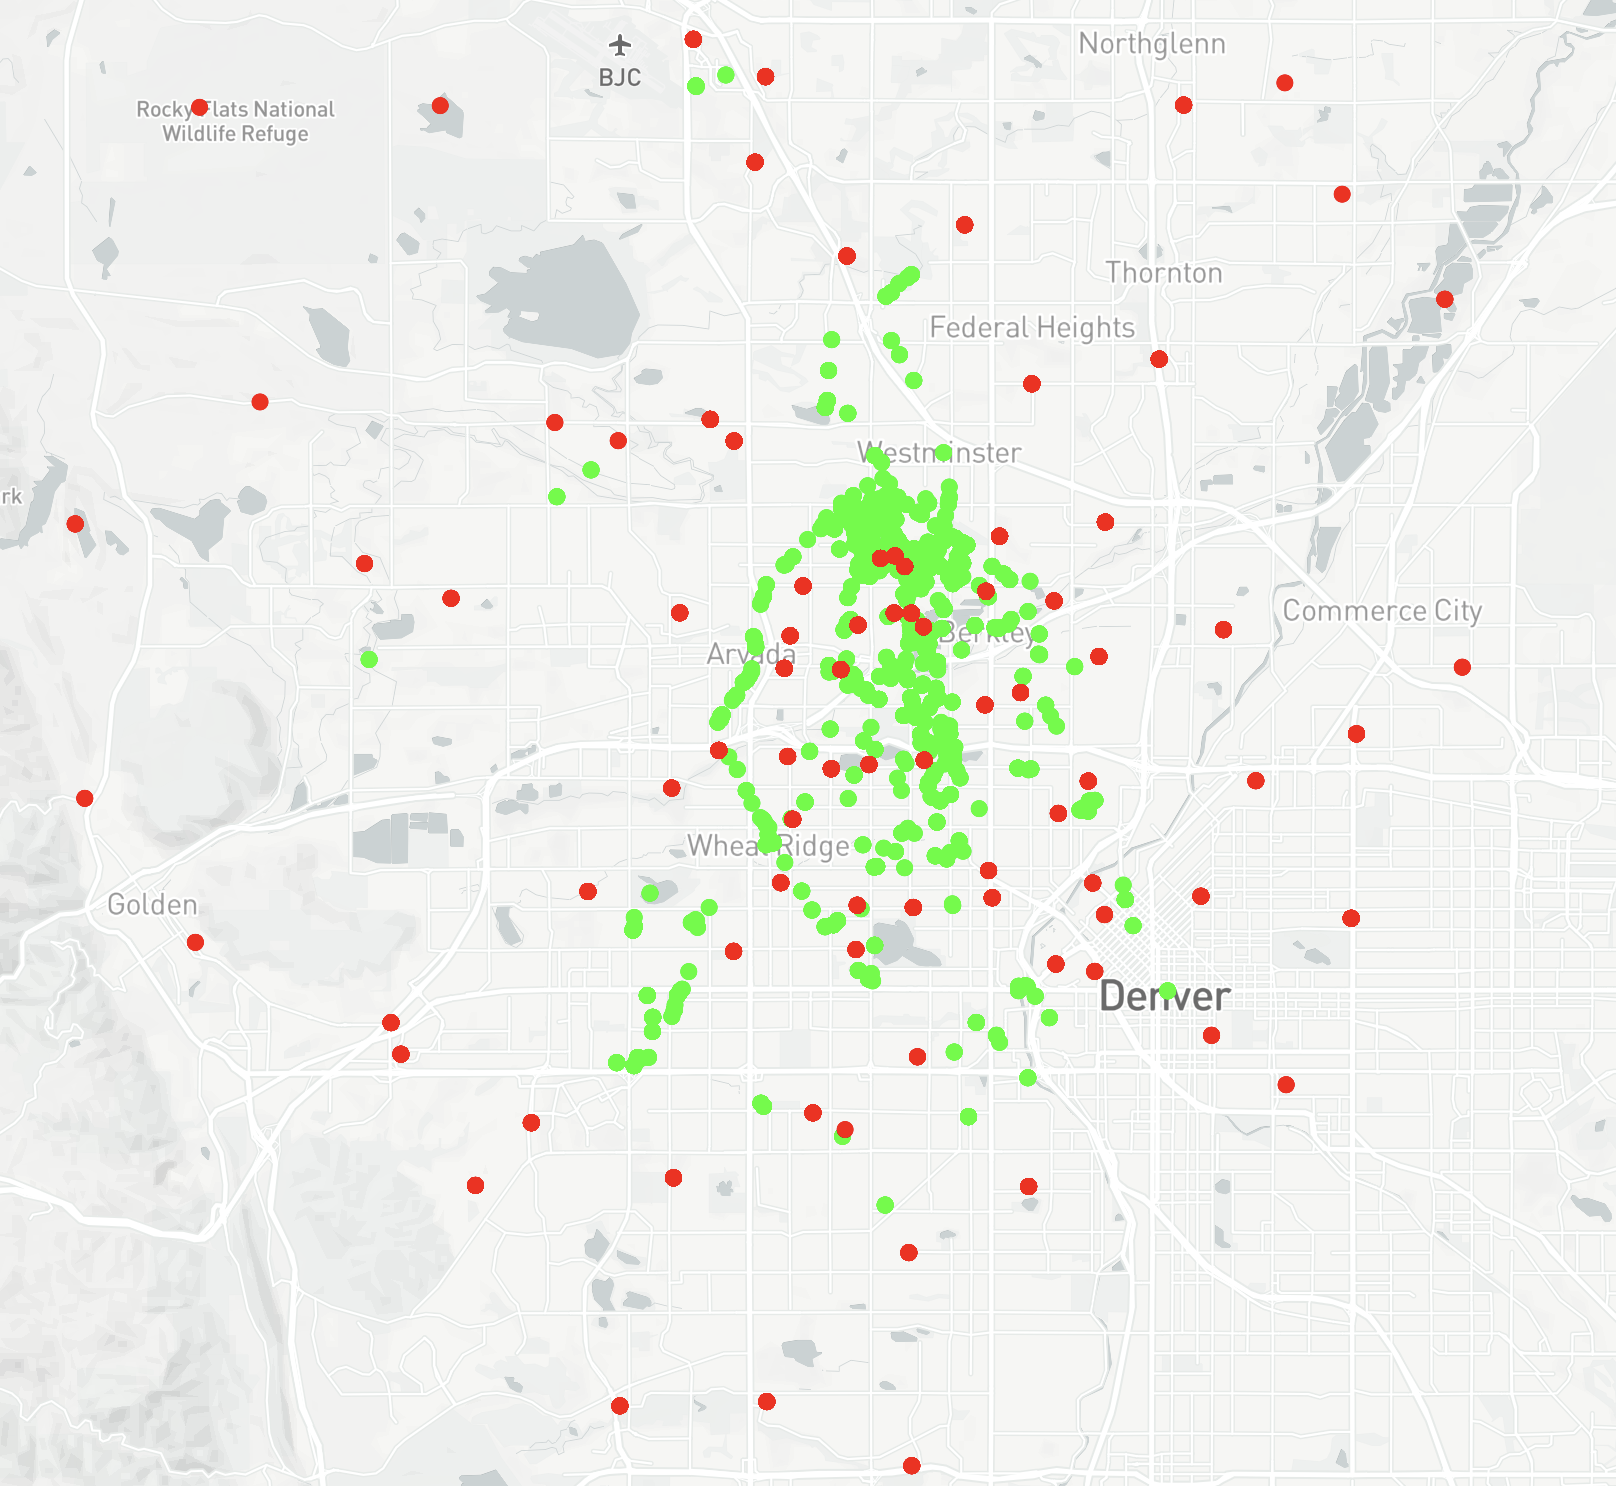

In [121]:
Image(filename='Device476185.png', width=500)

## Création des jeux d'entraînement et de validation
Notre but final étant d'obtenir une prédiction fiable et non sur-apprise, nous avons séparé le jeu d'entraînement "train" en deux :
- Un jeu d'apprentissage
- Un jeu de validation qui nous permet de vérifier la performance de nos prédictions sur des messages dont on connaît vraiment la position.

Pour que nos prédictions soient bonnes et non biaisées, les caractéristiques du jeu de validation doivent refléter le plus fidèlement possible les caractéristiques du jeu de test final sur lequel nous sommes évalués.

Nous avons donc fait en sorte de créer un jeu de validation ne comportant aucun device présent dans le jeu d'entraînement : ainsi notre algorithme ne "trichera pas" à l'entraînement et réalisera des prédictions sur des devices qu'il n'a jamais vu.

La création de ces jeux de données a été sauvegardée dans 2 fichiers CSV :
- **my_train_merged.csv** pour le jeu d'entraînement
- **my_test_merged.csv** pour le jeu validation


#### Créer deux listes (entrainement, validation) des devices

In [122]:
# Sort train dataset by device
df_mess_pos_sort = df_mess_pos.copy()
df_mess_pos_sort = df_mess_pos_sort.sort_values(by='did', ascending=True)
# Create the devices list
did_list_train = np.unique(df_mess_train['did'])
did_list_df = pd.DataFrame(did_list_train)
did_list_df.columns = ['did']
# Split devices into train and validation subsets, shuffle=True
did_list_train, did_list_test = model_selection.train_test_split(did_list_df, test_size = 0.25, shuffle=True)
did_list_train = did_list_train.sort_values(by='did', ascending=True)
did_list_test = did_list_test.sort_values(by='did', ascending=True)

#### Extraction des données relatives aux devices séléctionnées

In [123]:
# Merge splited devices with full dataset
df_train_merged = df_mess_pos_sort.merge(did_list_train, on='did')
df_test_merged = df_mess_pos_sort.merge(did_list_test, on='did')
# Write splitted data set to CSV
my_train_file = 'mytrain_merged.csv'
df_train_merged.to_csv(my_train_file, sep=',', index=False)
my_test_file = 'mytest_merged.csv'
df_test_merged.to_csv(my_test_file, sep=',', index=False)

## Préparation du jeu de données d'entraînement
### Analyse approfondie des erreurs de localisation

Nous avons approndi nos analyses pour mieux comprendre les erreurs de localisation des stations et tenter de les corriger.

#### Distribution des latitudes et des longitudes des stations


In [124]:
# Load train and test data

X_train = pd.read_csv('my_train_merged.csv') # train set
y_train = X_train[['lat','lng']]
#X_train = X_train.drop(columns=['lat', 'lng'])

#y_test = X_test.iloc[:, -2:]
#X_test = X_test.drop(columns=['lat', 'lng'])

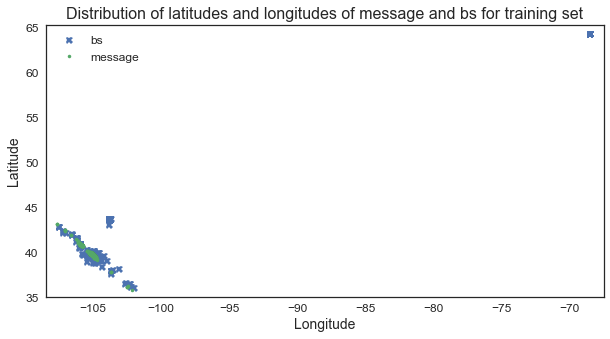

In [125]:
# Plotting latitudes and longitudes of bs and messages for training and test sets
plt.figure(figsize=(10,5))
plt.plot(X_train['bs_lng'], X_train['bs_lat'], 'X', label='bs')
plt.plot(X_train[['lng']], X_train[['lat']], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_train['bs_lng'].min()-1, X_train['bs_lng'].max()+1)
plt.ylim(X_train['bs_lat'].min()-1, X_train['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes of message and bs for training set')
plt.legend()


Ces représentations sont cohérentes avec les affiches sur cartes précédents.

#### Calcul des distances entre stations et messages

La première étape a consisté à calculer, pour chaque message reçu, quelle était la distance entre le message et les différentes stations l'ayant reçu. Concrètement nous avons **ajouté une colonne "distance" au DataFrame** en appelant la fonction de calcul de distance utilisant la formule de Haversine. Cette formule donne des résultats quasiment identiques à la formule proposée dans le dataset original mais sans les warning d'exécution.

In [126]:
#########################################
# Fonctions pour calculer les distances #
#########################################

def calc_distance_bs_message(X, pos):
    """ Option 1 utilisant la formule de Haversine"""
    df = X.join(pos)
    
    mess_lat = df['lat'] * np.pi / 180
    bs_lat = df['bs_lat'] * np.pi / 180
    mess_lng = df['lng'] * np.pi / 180
    bs_lng = df['bs_lng'] * np.pi / 180

    dlon = bs_lng - mess_lng
    dlat = bs_lat - mess_lat
    R = 6373
    a = (np.sin(dlat/2))**2 + np.cos(mess_lat) * np.cos(bs_lat) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c    
    
    return distance


def vincenty_vec(vec_coord):
    """ Option 2 avec la fonction fournie dans le notebook original """
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist


#########################################
# Calcule des distances                 #
#########################################
# Defining distances of datasets and distances to keep (option 1)
X_train['distance'] = calc_distance_bs_message(X_train.drop(columns=['lat','lng']), X_train[['lat','lng']])
#X_test['distance'] = calc_distance_bs_message(X_test, y_test)

## Defining distances of datasets and distances to keep (option 2)
#df = X_train.join(y_train)
#X_train['distance'] = vincenty_vec(df[['bs_lat', 'bs_lng', 'lat', 'lng']].values)
#X_train['distance'] /= 1000
#df = X_test.join(y_test)
#X_test['distance'] = vincenty_vec(df[['bs_lat', 'bs_lng', 'lat', 'lng']].values)
#X_test['distance'] /= 1000

#### Analyse de la distance en fonction du RSSI et identification des stations mal positionnées

Nous avons ensuite choisi d'explorer la relation entre les distances calculées et la puissance du signal reçu. Cela nous a permis de détecter des outliers et notamment d'identifier plus précisément les stations qui étaient mal postionnées ou dont la distance par rapport au RSSI n'était pas cohérente.

En explorant ces données de façons expérimentales à partir des graphiques, il nous a semblé cohérent de trouver une équation d'atténuation du signal en fonction de la distance qui nous permettrait de séparer les stations bien et mal positionnées. Après plusieurs essais, nous avons opté pour la fonction de limite de distance suivante :

$$DistanceLimite(rssi) = 0.06* \exp^{- \frac{rssi}{20}}$$

Comme on peut le voir sur les graphiques ci-après en trait orange, cette fonction suit la répartition des points et nous permet d'avoir un critère d'identification précis des stations mal positionnées.

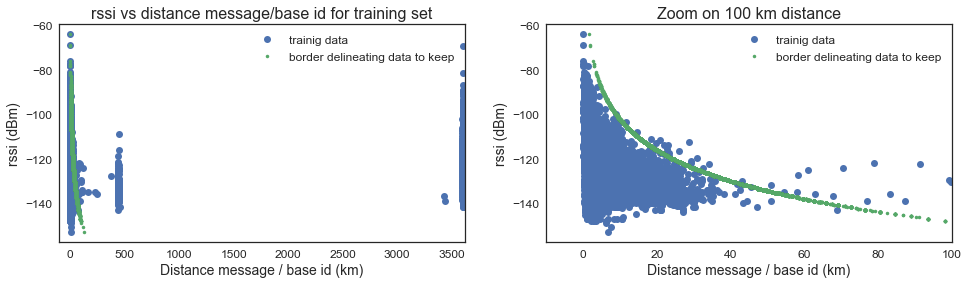

In [127]:
# Calcul de la distance limite des stations en fonction de la force du signal
d_keep_train = np.exp(- X_train['rssi'] / 20) * 0.06
#d_keep_test = np.exp(- X_test['rssi'] / 20) * 0.06

# Plotting distances and rssi of bs and messages for training set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_train['distance'], X_train['rssi'], 'o', label='trainig data')
plt.plot(d_keep_train, X_train['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt.xlim(-100, X_train['distance'].max())
plt. title('rssi vs distance message/base id for training set')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_train['distance'], X_train['rssi'], 'o', label='trainig data')
plt.plot(d_keep_train, X_train['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

#### Correction de la position des stations aberrantes

Afin de prédire la position des stations aux positions aberrantes, nous avons décidé de recourir au machine learning en utilisant un algorithme de RandomForest.

1. Tout d'abord nous avons séparé les données avec d'un côté les stations que nous avons estimées bien placées grâce au travail précédent, et pour lesquelles nous avons la position exacte, et de l'autre, les stations dont nous cherchons à prédire la latitude et la longitude.

2. Nous avons ensuite entraîné notre algorithme de RandomForest sur les stations bien placées et réalisé une prédiction pour les autres stations.

3. Pour l'entraînement du modèle, nous avons décidé de garder le maximum d'information en incluant les champs suivants : "rssi", "time_ux", "nseq", "lat", "lng" dans la matrice de feature. Intuitivement, le rssi, la longitude et la latitude seraient les informations les plus pertinentes mais nous avons conservé les autres.

4. Enfin nous avons réalisé plusieurs graphiques pour vérifier que nous avions bien corrigé les points aberrants.


In [128]:
# Fonction de correction des longitudes et latitudes des stations mal positionnées
def correct_lat_lng_misplaced_bs(X, y, d_keep):
    
    # On utlise un marqueur pour identifier les stations mal placées des autres.
    # Les stations mal placées sont celles dont la distance aux messages est supérieure
    # à la borde "d_keep" calculées précédemment.
    df = X.join(y)
    df['mul'] = 0
    df['mul'] = df['mul'].where(df['distance'] > d_keep, 1)

    df_1 = df.copy()
    df_1 = df_1.loc[df_1['mul'] != 0]
    df_2 = df.copy()
    df_2 = df_2.loc[df_2['mul'] == 0]

    X_train = df_1.copy()
    X_test = df_2.copy()
    
    # On utilise toutes les colonnes du DataFrame pour notre algorithme
    col = ['rssi', 'time_ux','nseq','lat', 'lng']
    X_train = X_train[col]
    X_test = X_test[col]
    ground_truth_lat = df_1['bs_lat']
    ground_truth_lng = df_1['bs_lng']
    
    # Entrainement d'une RandomForest
    clr = RandomForestRegressor(n_estimators=100)
    clr.fit(X_train, ground_truth_lat)
    y_pred_lat = clr.predict(X_test)

    clr.fit(X_train, ground_truth_lng)
    y_pred_lng = clr.predict(X_test)
    
    # Correction des positions
    df_2['bs_lat'] = df_2['bs_lat'] * df_2['mul'] + y_pred_lat
    df_2['bs_lng'] = df_2['bs_lng'] * df_2['mul'] + y_pred_lng

    # Préparation du résultat final avec calcul des nouvelles distances
    result = pd.concat([df_1, df_2])
    result = result.drop(columns=['mul','distance'])
    result['distance'] = calc_distance_bs_message(result.drop(columns=['lat','lng']), result[['lat','lng']])
    result['d_keep'] = d_keep        

    return result

In [293]:
# Corrected data
X_train_c = correct_lat_lng_misplaced_bs(X_train.drop(columns=['lat','lng']), X_train[['lat','lng']], d_keep_train)
#X_test_c, y_test_c = correct_lat_lng_misplaced_bs(X_test, y_test, d_keep_test)

À la sortie de la fonction précédente, le DataFrame X_train_c comporte les positions corrigées des stations aux positions aberrantes, ce que l'on peut constater en retraçant les différents graphiques précédents. De plus, on a rajoutté aux Dataframes X_train_c et X_test_c deux colonnes supplémentaires comportant les centroïdes (latitudes et longitudes) des stations ayant vu le même message.

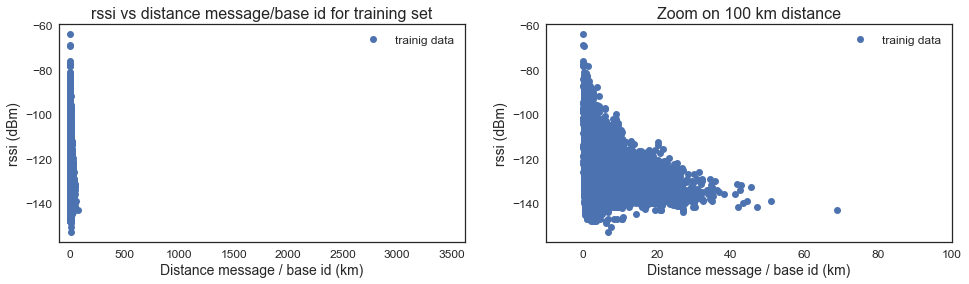

In [294]:
# Plotting distances and rssi of bs and messages for corrected training set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_train_c['distance'], X_train_c['rssi'], 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('rssi vs distance message/base id for training set')
plt.xlim(-100, X_train['distance'].max())
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_train_c['distance'], X_train_c['rssi'], 'o', label='trainig data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()


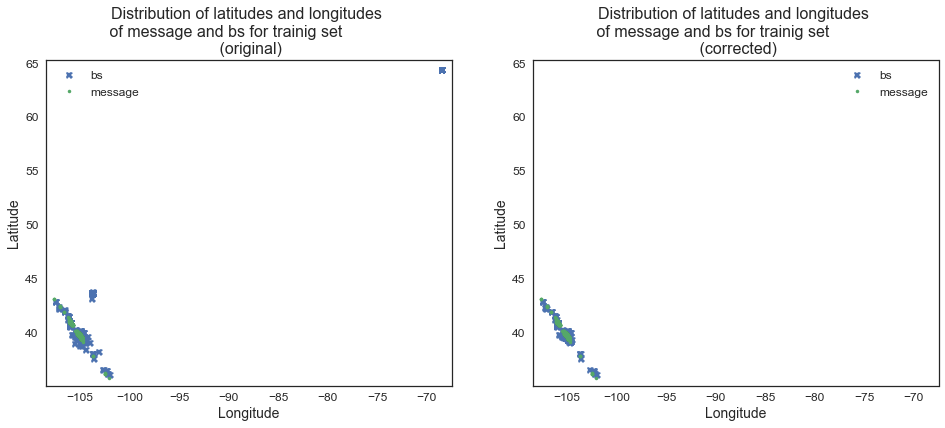

In [295]:
# Plotting latitudes and longitudes of bs and messages for training set
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(X_train['bs_lng'], X_train['bs_lat'], 'X', label='bs')
plt.plot(X_train['lng'], X_train['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_train['bs_lng'].min()-1, X_train['bs_lng'].max()+1)
plt.ylim(X_train['bs_lat'].min()-1, X_train['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (original)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_train_c['bs_lng'], X_train_c['bs_lat'], 'X', label='bs')
plt.plot(X_train['lng'], X_train['lat'], '.', label='message')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.xlim(X_train['bs_lng'].min()-1, X_train['bs_lng'].max()+1)
plt.ylim(X_train['bs_lat'].min()-1, X_train['bs_lat'].max()+1)
plt.title('Distribution of latitudes and longitudes \n of message and bs for trainig set \
          \n (corrected)')
plt.legend()


On constate que les stations aux positions aberrantes ou incohérentes ont été "ramenées" plus près du groupe de stations principal.

### Ajout d'une pénalité au niveau du RSSI

Tout d'abord on augmente de 0.5 la valeur de la colonne nseq pour eviter une division par 0.
Ensuite on divise la colonne rssi par la valeur du nseq correspondant au message pour prendre en avantager les entrées qui ont un numéro de sequence plus petit. Cette nouvelle valeur du rssi est sauvegardée dans une nouvelle colonne appellé newrssi.

In [296]:
# Add penalty on the rssi
X_train_c['nseq'] = X_train_c['nseq'] + 0.5
X_train_c['newrssi'] = X_train_c['rssi'] / X_train_c['nseq']

### Ajout de colonnes formées par les centroïdes en latitude et longitude des stations ayant vues le même message

On ajoutte deux colonnes aux datafram X_train_c comportant les centroïdes des stations ayant vue le même message.


In [297]:
# Add centroids columns to dataset
def add_centroid_bs(result):
    df_3 = pd.DataFrame({'messid': result.groupby(['messid']).mean().index,
                  'bs_lng_centroid': result.groupby(['messid'])['bs_lng'].mean().values,             
                  'bs_lat_centroid': result.groupby(['messid'])['bs_lat'].mean().values,             
                 })

    result = result.merge(df_3, on='messid')
    return result

In [298]:
X_train_c = add_centroid_bs(X_train_c)
X_train_c.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,distance,d_keep,newrssi,bs_lng_centroid,bs_lat_centroid
0,582ae1d712f1434b9ccad421,2189,473288.0,1.5,-127.0,1.479205e+12,39.817654,-105.050984,39.774984,-105.03944,4.847663,34.349563,-84.666667,-105.039722,39.768827
1,582ae1d712f1434b9ccad421,8352,473288.0,1.5,-124.0,1.479205e+12,39.761633,-105.025753,39.774984,-105.03944,1.890584,29.564942,-82.666667,-105.039722,39.768827
2,582ae1d712f1434b9ccad421,3579,473288.0,2.5,-120.0,1.479205e+12,39.755019,-105.043315,39.774984,-105.03944,2.245201,24.205728,-48.000000,-105.039722,39.768827
3,582ae1d712f1434b9ccad421,2731,473288.0,1.5,-101.0,1.479205e+12,39.781464,-105.040763,39.774984,-105.03944,0.729630,9.361348,-67.333333,-105.039722,39.768827
4,582ae1d712f1434b9ccad421,1859,473288.0,2.5,-125.0,1.479205e+12,39.704887,-105.016392,39.774984,-105.03944,8.042178,31.080769,-50.000000,-105.039722,39.768827


### Ajout de l'information sur le nombre de messages recus par chaque station

Cette information va donner plus de poid aux stations les plus puissantes

In [299]:
# Add number of messages received by each station 
def add_bsid_count_mess(result, bsid_count_mess):
    messid_list = result[['messid']].drop_duplicates()
    result = result.merge(bsid_count_mess, on='bsid')
    result = result.merge(messid_list, on='messid')
    return result

In [300]:
X_train_c = add_bsid_count_mess(X_train_c, df_bsid_count_mess)
X_train_c.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,distance,d_keep,newrssi,bs_lng_centroid,bs_lat_centroid,bs_count_mess
0,582ae1d712f1434b9ccad421,2189,473288.0,1.5,-127.0,1.479205e+12,39.817654,-105.050984,39.774984,-105.03944,4.847663,34.349563,-84.666667,-105.039722,39.768827,1443
1,582ae1d712f1434b9ccad421,8352,473288.0,1.5,-124.0,1.479205e+12,39.761633,-105.025753,39.774984,-105.03944,1.890584,29.564942,-82.666667,-105.039722,39.768827,800
2,582ae1d712f1434b9ccad421,3579,473288.0,2.5,-120.0,1.479205e+12,39.755019,-105.043315,39.774984,-105.03944,2.245201,24.205728,-48.000000,-105.039722,39.768827,901
3,582ae1d712f1434b9ccad421,2731,473288.0,1.5,-101.0,1.479205e+12,39.781464,-105.040763,39.774984,-105.03944,0.729630,9.361348,-67.333333,-105.039722,39.768827,647
4,582ae1d712f1434b9ccad421,1859,473288.0,2.5,-125.0,1.479205e+12,39.704887,-105.016392,39.774984,-105.03944,8.042178,31.080769,-50.000000,-105.039722,39.768827,1796


Nous avons introduit un certain nombre de nouvelles features pour notre jeu d'entraînement que nous garderons pour faire les predictions de positions de messages sur l'échantillon de validation. Ces nouvelles features sont:
- d_keep : limite de distance à garder, exprimée en fonction du rssi
- newrssi: pénalité introduite au niveau du rssi
- bs_lng_centroid :  centroïdes des longitudes des stations ayant vu le même message
- bs_lat_centroid :  centroïdes des latitudes des stations ayant vu le même message
- bs_count_mess:  pour donner plus de poid aux stations les plus puissantes
- distance: distance entre les messages et les stations calculée avec la formule de Haversine.

La dernière feature (distance) s'est avérée être très utile pour réduire les erreurs commises en gélocalisation. Par contre, son calcul requiert une estimation des latitudes et longitudes des messages. Or, ces quantités sont in fine celles qu'on cherche à calculer. Notez que dans le cas de notre échantillon de validation, on dispose déjà de la vérité terrain pour les latitudes et longitudes, mais cela n'est pas le cas pour le jeu de test final sur lequel on sera évalué. Par conséquent, on a choisi de procéder aux calculs des positions des messages comme si on ne disposait pas de la vérité terrain, en passant par 2 itérations:
- **lors de la première itération**: on obtient une estimation grossière des latitudes et des longitudes des messages. Cette estimation nous permet de calculer la feature distance. On peut alors également corriger la position des stations situées dans des endroits aberrants.
- **lors de la deuxième itération**: tout d'abord on utilise les positions des nouvelles stations corrigées pour calculer les features bs_lng_centroid et bs_lat_centroid. Ensuite, on prépare notre matrice de features (incluant d_keep, newrrsi, bs_lng_centroid, etc.) pour prédire plus précisemment les positions des messages.



# Prédictions de la position des messages pour le jeu de données de validation

Ayant préparé le jeu d'entraînement, on peut procéder aux différents essais de prédictions de la position des messages pour les jeux de validation. On commence par charger le jeu de validation.

In [136]:
X_test = pd.read_csv('my_test_merged.csv') # test set
y_test = X_test[['lat','lng']]
#X_test = X_test.drop(columns=['lat', 'lng'])

## Première itération
### Création de la matrice de features

Pour estimer grossièrement les positions des latitudes et des longitudes des messages, la matrice des features comporte: 
- 4418 lignes correspondant aux messages uniques des jeux d'entraînement et validation
- 251 colonnes correspondant aux 251 différentes stations sans aucune caractéristique particulière.

In [137]:
# determine all Base stations that received at least 1 message
listOfBs = np.union1d(np.unique(X_train_c['bsid']), np.unique(X_test['bsid']))

In [192]:
def feat_mat_const_iter1(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = 1
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message

In [193]:
# Generate train features matrix
df_feat_1, id_list_train_1 = feat_mat_const_iter1(X_train_c, listOfBs)
df_feat_1.head()

,879,911,921,944,980,1012,1086,1092,1120,1148,...,8747,9784,9899,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
# Generate test features matrix
df_feat_test_1, id_list_test_1 = feat_mat_const_iter1(X_test, listOfBs)
df_feat_test_1.head()

,879,911,921,944,980,1012,1086,1092,1120,1148,...,8747,9784,9899,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modèle et prédictions

In [195]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng
    
    X_train = np.array(df_feat);

    reg = ExtraTreesRegressor(n_estimators=100, n_jobs = -1, max_features=1.0, random_state=2792, bootstrap=True)

    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test)
    print("Prédiction lat OK")

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test)
    print("Prédiction lng OK")
    
    return y_pred_lat, y_pred_lng

Pour les valeurs "Ground_truth", nous avons utilisé la fonction proposés dans le cours.

In [174]:
# ground truth construction
def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [196]:
gr_truth_lat_train, gr_truth_lng_train = ground_truth_const(X_train_c, X_train_c[['lat','lng']])
gr_truth_lat_test, gr_truth_lng_test = ground_truth_const(X_test, X_test[['lat','lng']])
print("Nb messages Train : {:d} \nNb messages Test : {:d}"\
      .format(gr_truth_lat_train.shape[0],gr_truth_lat_test.shape[0] ))

Nb messages Train : 4418 
Nb messages Test : 1650


In [197]:
y_pred_lat_1, y_pred_lng_1 = regressor_and_predict(df_feat_1, gr_truth_lat_train, gr_truth_lng_train, 
                                            df_feat_test_1)

Prédiction lat OK
Prédiction lng OK


### Calcul des distances entre stations et messages

On utilise les latitudes et longitudes calculées à partir du modèle de régression non linéaire utilisé lors de la première itération.

In [198]:
# Tmp dataframe
tmp = pd.DataFrame({'messid': id_list_test_1,
                        'lat': y_pred_lat_1,
                        'lng': y_pred_lng_1,
                        })

X_test['distance'] = calc_distance_bs_message(X_test.drop(columns=['lat', 'lng']),  
                                        X_test.drop(columns=['lat','lng']).merge(tmp, on='messid')[['lat','lng']])

### Analyse de la distance en fonction du RSSI et identification des stations mal positionnées

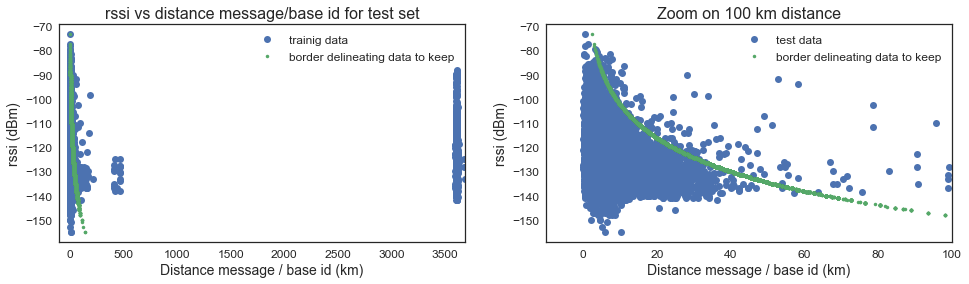

In [199]:
# Calcul de la distance limite des stations en fonction de la force du signal
d_keep_test = np.exp(- X_test['rssi'] / 20) * 0.06

# Plotting distances and rssi of bs and messages for training set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_test['distance'], X_test['rssi'], 'o', label='trainig data')
plt.plot(d_keep_test, X_test['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt.xlim(-100, X_test['distance'].max())
plt. title('rssi vs distance message/base id for test set')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test['distance'], X_test['rssi'], 'o', label='test data')
plt.plot(d_keep_test, X_test['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

### Correction de la position des stations aberrantes

In [301]:
X_test_c = correct_lat_lng_misplaced_bs(X_test.drop(columns=['lat','lng']), X_test[['lat','lng']], d_keep_test)

À la sortie de la fonction précédente, le DataFrame X_test_c comporte les positions corrigées des stations aux positions aberrantes, ce que l'on peut constater en retraçant les différents graphiques précédents.

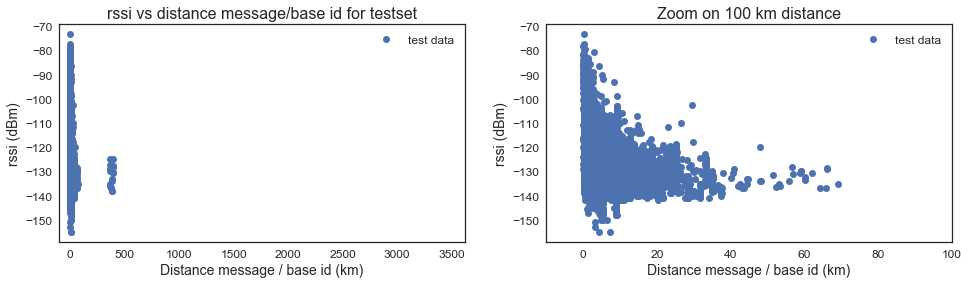

In [302]:
# Plotting distances and rssi of bs and messages for corrected test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_test_c['distance'], X_test_c['rssi'], 'o', label='test data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('rssi vs distance message/base id for testset')
plt.xlim(-100, X_train['distance'].max())
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test_c['distance'], X_test_c['rssi'], 'o', label='test data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

### Ajout d'une pénalité au niveau du RSSI

In [303]:
# Add penalty on the rssi
X_test_c['nseq'] = X_test_c['nseq'] + 0.5
X_test_c['newrssi'] = X_test_c['rssi'] / X_test_c['nseq']

### Ajout de colonnes formées par les centroïdes en latitude et longitude des stations ayant vues le même message

On ajoutte deux colonnes aux datafram X_test_c comportant les centroïdes des stations ayant vue le même message.

In [304]:
X_test_c = add_centroid_bs(X_test_c)

### Ajout de l'information sur le nombre de messages recus par chaque station

Cette information va donner plus de poid aux stations les plus puissantes

In [306]:
X_test_c = add_bsid_count_mess(X_test_c, df_bsid_count_mess)
X_test_c.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,distance,d_keep,newrssi,bs_lng_centroid,bs_lat_centroid,bs_count_mess
0,57599f09864fce568932b7f5,1859,473805.0,0.5,-129.000000,1.465491e+12,39.704887,-105.016392,39.7053,-104.973442,3.675733,37.962138,-258.000000,-105.05006,39.756544,1796
1,57599f09864fce568932b7f5,1872,473805.0,0.5,-133.000000,1.465491e+12,39.823856,-105.239120,39.7053,-104.973442,26.265792,46.367060,-266.000000,-105.05006,39.756544,476
2,57599f09864fce568932b7f5,2617,473805.0,1.5,-141.333333,1.465491e+12,39.779908,-105.062479,39.7053,-104.973442,11.263163,70.334044,-94.222222,-105.05006,39.756544,1382
3,57599f09864fce568932b7f5,3548,473805.0,2.5,-134.000000,1.465491e+12,39.744848,-105.010048,39.7053,-104.973442,5.399837,48.744350,-53.600000,-105.05006,39.756544,1037
4,57599f09864fce568932b7f5,3846,473805.0,2.5,-135.000000,1.465491e+12,39.753719,-104.998668,39.7053,-104.973442,5.801865,51.243526,-54.000000,-105.05006,39.756544,736


## Deuxième itération
### Création de la matrice de features

Pour la matrice de feature, nous avons décidé de garder le maximum d'information possible par rapport au jeu de données. Pour cela, nous avons transformé les lignes en colonnes de telle sorte que pour chaque message, on a non seulement la liste des stations qui l'a reçu mais également toutes les caractéristiques du message reçu pour chaque station.

Autrement dit notre matrice de feature comporte les élements suivants :
- **6068** lignes correspondant aux messages uniques
- **2008** colonnes correspondant à 251 stations*8 caractéristiques par station:
    - rssi
    - longitude station
    - latitude station
    - centroïde des latitudes des stations ayant vu le même message
    - centroïde des longitudes des stations ayant vu le même message
    - distance (approximative) calculée entre la station et le message
    - distance maximum calculée en fonction de la puissance du signal
    - pénalité au niveau du rssi

Après plusieurs tests, nous n'avons pas retenu la valeur "nseq" pour prédire la position des messages, car cette information ne nous semble pas suffisamment corrélée à la position. De même les résultats incluant la valeur de time_ux ne semblent pas apporter d'amélioration tels quels.

Nous avons également créé cette matrice de feature pour le jeu de validation.

In [310]:
# Feature Matrix construction 
#def feat_mat_const(df_mess_train, df_count, listOfBs):
def feat_mat_const(df_mess_train, listOfBs):
    lat_listOfBs = ['lat_' + s for s in list(listOfBs.astype(str))]
    lng_listOfBs = ['lng_' + s for s in list(listOfBs.astype(str))]
    dist_listOfBs = ['dist_' + s for s in list(listOfBs.astype(str))]
    newrssi_listOfBs = ['newrssi_' + s for s in list(listOfBs.astype(str))]
    dkeep_listOfBs = ['dkeep_' + s for s in list(listOfBs.astype(str))]
    clat_listOfBs = ['clat_' + s for s in list(listOfBs.astype(str))]
    clng_listOfBs = ['clng_' + s for s in list(listOfBs.astype(str))]
    bscm_listOfBs = ['bscm_' + s for s in list(listOfBs.astype(str))]
    #nseq_listOfBs = ['nseq_' + s for s in list(listOfBs.astype(str))]
    #timeux_listOfBs = ['timeux_' + s for s in list(listOfBs.astype(str))]
    
    feature_cols = list(listOfBs.astype(str)) \
                    + lat_listOfBs + lng_listOfBs \
                    + dist_listOfBs \
                    + bscm_listOfBs \
                    + dkeep_listOfBs \
                    + newrssi_listOfBs \
                    + clat_listOfBs + clng_listOfBs 
                    #+ nseq_listOfBs
                    #+ timeux_listOfBs                    
                          
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(feature_cols))), columns = feature_cols) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:  
        #print(key)
        df_mess_bs_group.get_group(key)
        bsid_list = df_mess_bs_group.get_group(key)['bsid'].astype(str)
        lat_bsid_list = ['lat_' + s for s in list(bsid_list.astype(str))]
        lng_bsid_list = ['lng_' + s for s in list(bsid_list.astype(str))]
        dist_bsid_list = ['dist_' + s for s in list(bsid_list.astype(str))]
        newrssi_bsid_list = ['newrssi_' + s for s in list(bsid_list.astype(str))]
        dkeep_bsid_list = ['dkeep_' + s for s in list(bsid_list.astype(str))]
        clat_bsid_list = ['clat_' + s for s in list(bsid_list.astype(str))]
        clng_bsid_list = ['clng_' + s for s in list(bsid_list.astype(str))]       
        bscm_bsid_list = ['bscm_' + s for s in list(bsid_list.astype(str))]        
        #timeux_bsid_list = ['timeux_' + s for s in list(bsid_list.astype(str))]        
        
        rssi_list = df_mess_bs_group.get_group(key)['rssi']
        bs_lat_list = df_mess_bs_group.get_group(key)['bs_lat']
        bs_lng_list = df_mess_bs_group.get_group(key)['bs_lng']
        bs_clat_list = df_mess_bs_group.get_group(key)['bs_lat_centroid']
        bs_clng_list = df_mess_bs_group.get_group(key)['bs_lng_centroid']        
        dist_list = df_mess_bs_group.get_group(key)['distance']
        bscm_list = df_mess_bs_group.get_group(key)['bs_count_mess']
        newrssi_list = df_mess_bs_group.get_group(key)['newrssi']
        dkeep_list = df_mess_bs_group.get_group(key)['d_keep']
        #timeux_list = df_mess_bs_group.get_group(key)['time_ux']
        #nseq_list = df_mess_bs_group.get_group(key)['nseq']        
        
        df_feat.loc[idx, bsid_list] = rssi_list.values
        df_feat.loc[idx, lat_bsid_list] = bs_lat_list.values
        df_feat.loc[idx, lng_bsid_list] = bs_lng_list.values
        df_feat.loc[idx, clat_bsid_list] = bs_clat_list.values
        df_feat.loc[idx, clng_bsid_list] = bs_clng_list.values
        df_feat.loc[idx, dist_bsid_list] = dist_list.values   
        df_feat.loc[idx, bscm_bsid_list] = bscm_list.values
        df_feat.loc[idx, newrssi_bsid_list] = newrssi_list.values        
        df_feat.loc[idx, dkeep_bsid_list] = dkeep_list.values        
        #df_feat.loc[idx, timeux_bsid_list] = timeux_list.values   
        #df_feat.loc[idx, nseq_bsid_list] = nseq_list.values
                
        id_list[idx] = key
        idx = idx + 1
    
    #df_feat['count'] = df_count['count']
    return df_feat, id_list # add id value of each message for the correspondance to message

In [311]:
# Generate train features matrix
#df_feat, id_list_train = feat_mat_const(X_train_c, df_count_X_train_c, listOfBs)
df_feat, id_list_train = feat_mat_const(X_train_c, listOfBs)

df_feat.head()

,879,911,921,944,980,1012,1086,1092,1120,1148,...,clng_8747,clng_9784,clng_9899,clng_10134,clng_10148,clng_10151,clng_10162,clng_10999,clng_11007,clng_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [312]:
# Generate test features matrix
df_feat_test, id_list_test = feat_mat_const(X_test_c, listOfBs)
df_feat_test.head()

,879,911,921,944,980,1012,1086,1092,1120,1148,...,clng_8747,clng_9784,clng_9899,clng_10134,clng_10148,clng_10151,clng_10162,clng_10999,clng_11007,clng_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,-141.0,0.0,0.0,0.0,...,0.0,0.0,-105.033121,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [313]:
gr_truth_lat_train, gr_truth_lng_train = ground_truth_const(X_train_c.drop(columns=['lat','lng']), X_train_c[['lat','lng']])
gr_truth_lat_test, gr_truth_lng_test = ground_truth_const(X_test_c.drop(columns=['lat','lng']), X_test_c[['lat','lng']])
print("Nb messages Train : {:d} \nNb messages Test : {:d}"\
      .format(gr_truth_lat_train.shape[0],gr_truth_lat_test.shape[0] ))

Nb messages Train : 4418 
Nb messages Test : 1650


### Modèle et prédictions

In [314]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, 
                                        df_feat_test)


Prédiction lat OK
Prédiction lng OK


## Évaluation des résultats sur le jeu de données de validation

L'évaluation des résultats est réalisée comme dans le notebook original en calculant les erreurs cumulées sur les prédictions.

In [190]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [315]:
err_vec = Eval_geoloc(gr_truth_lat_test , gr_truth_lng_test, y_pred_lat, y_pred_lng)

# Error criterion
print(f"L'erreur à 80 % pour le jeu de données de validation est de {round(np.percentile(err_vec, 80),2)} m")

L'erreur à 80 % pour le jeu de données de validation est de 2777.98 m


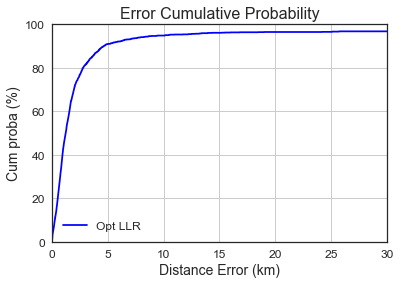

In [316]:
# Plot error distribution
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

Text(0.5, 1.0, 'Predictions lat')

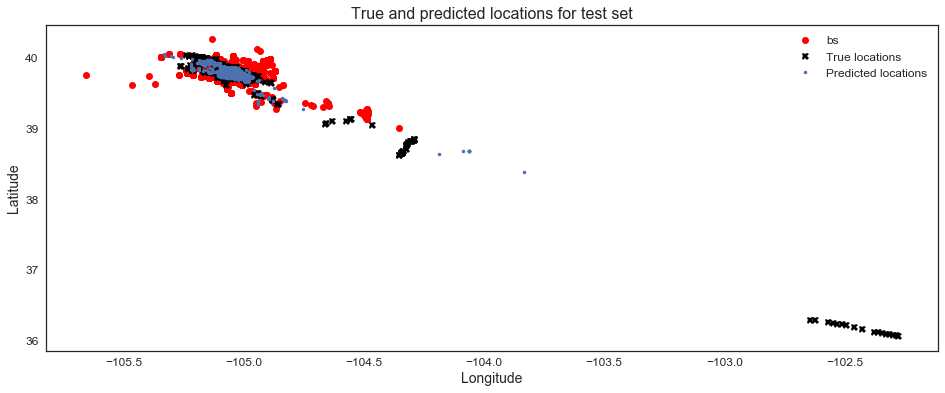

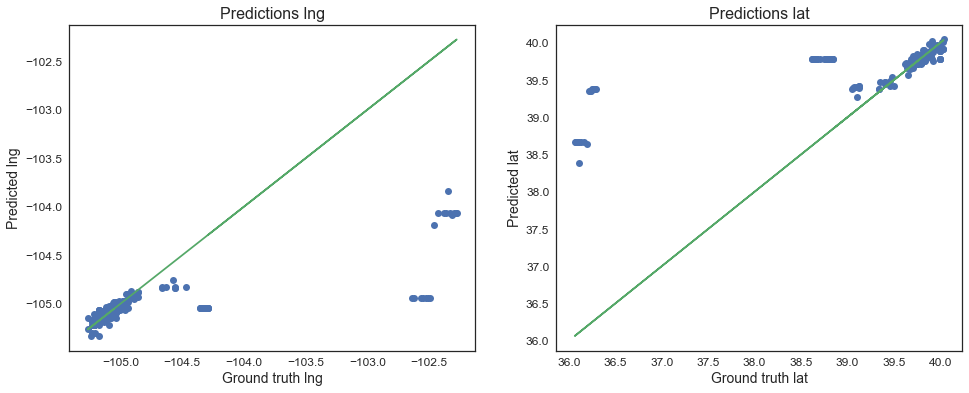

In [317]:
# Plot of true and predicted locations for test set
plt.figure(figsize=(16,6))
plt.plot(X_test_c['bs_lng'], X_test_c['bs_lat'], 'ro', label='bs')
plt.plot(gr_truth_lng_test, gr_truth_lat_test, 'kX', label='True locations')
plt.plot(y_pred_lng, y_pred_lat, '.', label='Predicted locations')
plt.xlabel('Longitude' )
plt.ylabel('Latitude')
plt.title('True and predicted locations for test set')
plt.legend()

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(gr_truth_lng_test, y_pred_lng,'o')
plt.plot(gr_truth_lng_test, gr_truth_lng_test)
#plt.plot(gr_truth_lng_test, gr_truth_lng_test-0.3, 'k')
#plt.plot(gr_truth_lng_test, gr_truth_lng_test+0.3, 'k')
plt.xlabel('Ground truth lng')
plt.ylabel('Predicted lng')
plt.title('Predictions lng')

plt.subplot(1,2,2)
plt.plot(gr_truth_lat_test, y_pred_lat,'o', label='bs')
plt.plot(gr_truth_lat_test, gr_truth_lat_test)
#plt.plot(gr_truth_lat_test, gr_truth_lat_test-0.3, 'k')
#plt.plot(gr_truth_lat_test, gr_truth_lat_test+0.3, 'k')
plt.xlabel('Ground truth lat')
plt.ylabel('Predicted lat')
plt.title('Predictions lat')


D'après le premier graphique ci-dessus, on constate que la grappe centrale de message semble plutôt bien prédite tandis qu'un certain nombre de messages ne sont pas bien prédits, notamment au sud est et au centre vers la longitude 104. Ceci est confirmé par le deuxième graphique.

# Création du fichier final pour validation

## Chargement des données

In [318]:
X_train_f = pd.read_csv('mess_train_list.csv')
X_test_f = pd.read_csv('mess_test_list.csv')
y_train_f = pd.read_csv('pos_train_list.csv')
X_train_f = pd.concat([X_train_f, y_train_f], axis=1, sort=False)

## Preparation du jeu de données d'entraînement

In [319]:
X_train_f['distance'] = calc_distance_bs_message(X_train_f.drop(columns=['lat','lng']), X_train_f[['lat','lng']])
d_keep_train_f = np.exp(- X_train_f['rssi'] / 20) * 0.06

# Corrected data
X_train_fc = correct_lat_lng_misplaced_bs(X_train_f.drop(columns=['lat','lng']), X_train_f[['lat','lng']], d_keep_train_f)

# Add penalty on the rssi
X_train_fc['nseq'] = X_train_fc['nseq'] + 0.5
X_train_fc['newrssi'] = X_train_fc['rssi'] / X_train_fc['nseq']

# Centroid columns
X_train_fc = add_centroid_bs(X_train_fc)

# Add number of messages received by each station 
X_train_fc = add_bsid_count_mess(X_train_fc, df_bsid_count_mess)

X_train_fc.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,distance,d_keep,newrssi,bs_lng_centroid,bs_lat_centroid,bs_count_mess
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,1.0,-121.500000,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,1.272501,26.090970,-121.500000,-104.953819,39.647522,144
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.5,-125.000000,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,7.864086,31.080769,-50.000000,-104.953819,39.647522,279
2,573cc3e1864fce1a9a7e8cac,2841,473335.0,1.5,-108.000000,1.463600e+12,39.617794,-104.954917,39.610840,-104.959205,0.856339,13.284385,-72.000000,-104.953819,39.647522,144
3,573cc3e1864fce1a9a7e8cac,3526,473335.0,2.5,-137.000000,1.463600e+12,39.677251,-104.952721,39.610840,-104.959205,7.407784,56.632854,-54.800000,-104.953819,39.647522,279
4,573cc5753e952e1912f0d833,2841,473335.0,1.5,-131.333333,1.463601e+12,39.617794,-104.954917,39.610485,-104.958663,0.874031,42.659754,-87.555556,-104.954917,39.617794,144


## Prédictions de la position des messages pour le jeu de données de test final

In [320]:
# determine all Base stations that received at least 1 message
listOfBs_f = np.union1d(np.unique(X_train_fc['bsid']), np.unique(X_test_f['bsid'])) 

### Première itération

In [322]:
# Generate train features matrix
df_feat_f1, id_list_train_f1 = feat_mat_const_iter1(X_train_fc, listOfBs_f)
df_feat_f1.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [323]:
# Generate test features matrix
df_feat_test_f1, id_list_test_f1 = feat_mat_const_iter1(X_test_f, listOfBs_f)
df_feat_test_f1.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [324]:
gr_truth_lat_train_f, gr_truth_lng_train_f = ground_truth_const(X_train_fc, X_train_fc[['lat','lng']])
print("Nb messages Train : {:d}"\
      .format(gr_truth_lat_train_f.shape[0]))

Nb messages Train : 6068


In [325]:
y_pred_lat_f1, y_pred_lng_f1 = regressor_and_predict(df_feat_f1, gr_truth_lat_train_f, gr_truth_lng_train_f, 
                                               df_feat_test_f1)

Prédiction lat OK
Prédiction lng OK


In [326]:
# Tmp dataframe
tmp = pd.DataFrame({'messid': id_list_test_f1,
                        'lat': y_pred_lat_f1,
                        'lng': y_pred_lng_f1,
                        })
# Distance computation
X_test_f['distance'] = calc_distance_bs_message(X_test_f,  X_test_f.merge(tmp, on='messid')[['lat','lng']])

# Adding the computed lat and lng columns
X_test_f['lat'] = X_test_f.merge(tmp, on='messid')['lat']
X_test_f['lng'] = X_test_f.merge(tmp, on='messid')['lng']

In [327]:
# Calcul de la distance limite des stations en fonction de la force du signal
d_keep_test_f = np.exp(- X_test_f['rssi'] / 20) * 0.06

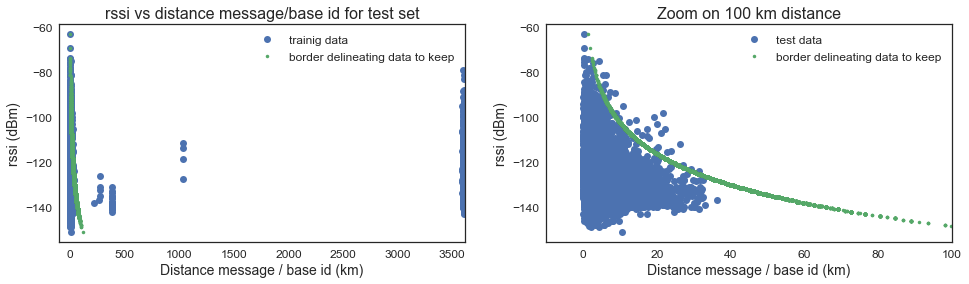

In [328]:
# Plotting distances and rssi of bs and messages for test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_test_f['distance'], X_test_f['rssi'], 'o', label='trainig data')
plt.plot(d_keep_test_f, X_test_f['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt.xlim(-100, X_test_f['distance'].max())
plt. title('rssi vs distance message/base id for test set')
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test_f['distance'], X_test_f['rssi'], 'o', label='test data')
plt.plot(d_keep_test_f, X_test_f['rssi'],'.', label='border delineating data to keep')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

In [329]:
# Correcting positions
X_test_fc = correct_lat_lng_misplaced_bs(X_test_f.drop(columns=['lat','lng']), X_test_f[['lat','lng']], d_keep_test_f)


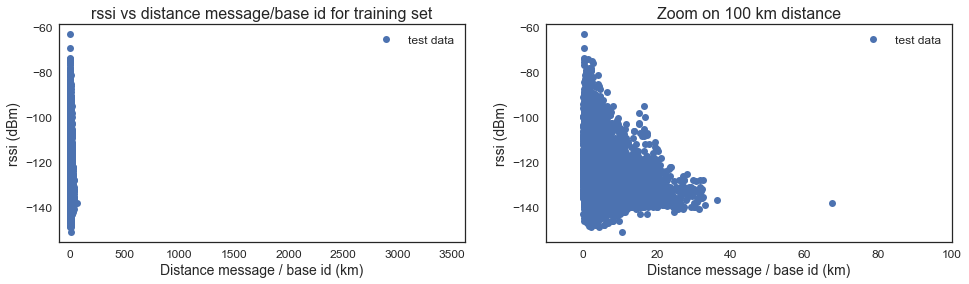

In [330]:
# Plotting distances and rssi of bs and messages for corrected test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(X_test_fc['distance'], X_test_fc['rssi'], 'o', label='test data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('rssi vs distance message/base id for training set')
plt.xlim(-100, X_test_f['distance'].max())
plt.legend()

plt.subplot(1,2,2)
plt.plot(X_test_fc['distance'], X_test_fc['rssi'], 'o', label='test data')
plt.xlabel('Distance message / base id (km)' )
plt.ylabel('rssi (dBm)')
plt. title('Zoom on 100 km distance')
plt.xlim(-10,100)
plt.legend()

In [331]:
# Add penalty on the rssi
X_test_fc['nseq'] = X_test_fc['nseq'] + 0.5
X_test_fc['newrssi'] = X_test_fc['rssi'] / X_test_fc['nseq']

In [332]:
# Add centroids columns
X_test_fc = add_centroid_bs(X_test_fc)

In [333]:
# Add number of messages received by each station 
X_test_fc = add_bsid_count_mess(X_test_fc, df_bsid_count_mess)

### Deuxième itération

In [335]:
# Generate train features matrix
df_feat_f, id_list_train_f = feat_mat_const(X_train_fc, listOfBs_f)

df_feat_f.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,clng_9936,clng_9941,clng_9949,clng_10134,clng_10148,clng_10151,clng_10162,clng_10999,clng_11007,clng_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,-141.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
# Generate test features matrix
df_feat_test_f, id_list_test_f = feat_mat_const(X_test_fc, listOfBs_f)
df_feat_test_f.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,clng_9936,clng_9941,clng_9949,clng_10134,clng_10148,clng_10151,clng_10162,clng_10999,clng_11007,clng_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##  Prédictions dataset test final

In [341]:
y_pred_lat_f, y_pred_lng_f = regressor_and_predict(df_feat_f, gr_truth_lat_train_f, gr_truth_lng_train_f, 
                                            df_feat_test_f)

Prédiction lat OK
Prédiction lng OK


## Génération du fichier final

In [342]:
test_res = pd.DataFrame(np.array([y_pred_lat_f, y_pred_lng_f]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test_f
test_res.to_csv('pred_pos_test_list.csv', index=False)
test_res.head()

,lat,lng,messid
0,39.779876,-105.048140,573be2503e952e191262c351
1,39.763085,-105.074533,573c05f83e952e1912758013
2,39.680657,-105.020490,573c0796f0fe6e735a66deb3
3,39.784306,-105.074173,573c08d2864fce1a9a0563bc
4,39.680549,-105.021331,573c08ff864fce1a9a0579b0
